In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import datetime

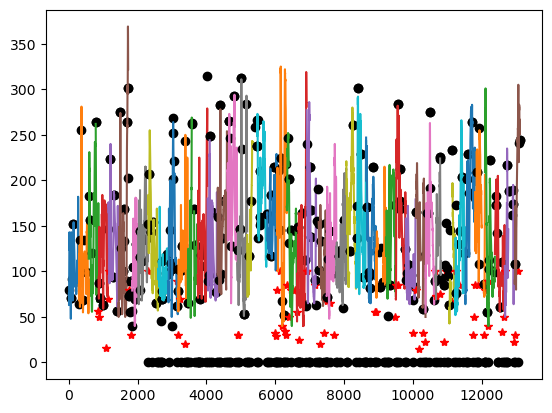

In [3]:
# Load the dataset
df = pd.read_csv("../../data/Ohio2020_processed/train/540-ws-training_processed.csv")
# Start time samples from zero
df["5minute_intervals_timestamp"] = df["5minute_intervals_timestamp"] - df["5minute_intervals_timestamp"][0]

filtered_df_carbs = df[df["carbInput"].notnull()]
filtered_df_finger = df[df["finger"].notnull()]
for i in range(13*4):
    start = i*288
    end = (i+1)*288
    # plt.figure()
    plt.plot(df["5minute_intervals_timestamp"][start:end], df["carbInput"][start:end], "r*", label="CarbInput")
    plt.plot(df["5minute_intervals_timestamp"][start:end], df["finger"][start:end], "ko", label="CarbInput")
    plt.plot(df["5minute_intervals_timestamp"][start:end], df["cbg"][start:end], label="CarbInput")

In [4]:
def append_if_in_range(subset_a, subset_b, distance=6):
    ranges = [(idx - distance, idx + distance) for idx in subset_a.index]  # Create ranges around each index in A
    
    # Function to check if the index is within any range
    def in_any_range(idx):
        return any(start <= idx <= end for start, end in ranges)
    
    # Create a new dataframe for valid entries in subset B
    valid_b = subset_b[subset_b.index.to_series().apply(in_any_range)]
    
    # Append the valid rows from subset B to subset A
    result = pd.concat([subset_a, valid_b], join="outer").drop_duplicates().sort_index()
    
    return result

In [5]:
# List of DataFrame indexes 
carbIntake = []

# Filter for carb intake, where carb intake is not null
filtered_df_carbs = df[df["carbInput"].notnull()]
sampling_time = 5
nbr_of_mins = 10
nbr_of_hours = 4

nbr_of_time_steps =int(nbr_of_mins/sampling_time)
nbr_of_samples_per_h = int(np.floor(60/nbr_of_mins))
nbr_of_total_samples = nbr_of_samples_per_h*nbr_of_hours

for index, row in filtered_df_carbs.iterrows():
    carbIntakePerIndex = []
    for i in range(nbr_of_total_samples):
        try:
            carbIntakePerIndex.append(df.iloc[index+i*nbr_of_time_steps])
        except:
            print(f"Sample {index+i*nbr_of_samples_per_h} is out of range")
            break
    # display(pd.DataFrame(carbIntakePerIndex))
    carbIntakePerIndex_df = pd.DataFrame(carbIntakePerIndex)
        
    # Include all indeces of further carb intakes between the indeces
    carbIntakePerIndex_df = append_if_in_range(carbIntakePerIndex_df, filtered_df_carbs)
    values = carbIntakePerIndex_df.index.to_list()
    carbIntakePerIndex_df["minAfterMeal"] = [(x-values[0])*5 for x in values]

    carbIntake.append(carbIntakePerIndex_df.fillna(0).drop(["5minute_intervals_timestamp"], axis=1).reset_index(drop=True))

    


In [6]:
carbIntake

[    missing_cbg    cbg  finger  basal   hr       gsr  carbInput  bolus  \
 0           0.0   84.0     0.0   0.95  0.0  0.007625       57.0    0.0   
 1           0.0   78.0     0.0   0.95  0.0  0.000000        0.0    0.0   
 2           0.0   72.0     0.0   0.95  0.0  0.024066        0.0    0.0   
 3           0.0   68.0     0.0   0.95  0.0  0.006154        0.0    0.0   
 4           0.0   91.0     0.0   0.95  0.0  0.008535        0.0    6.3   
 5           0.0  136.0     0.0   0.95  0.0  0.011371        0.0    0.0   
 6           0.0  161.0     0.0   0.95  0.0  0.010671        0.0    0.0   
 7           0.0  175.0     0.0   0.95  0.0  0.012545        0.0    0.0   
 8           0.0  163.0     0.0   0.95  0.0  0.010346        0.0    0.0   
 9           0.0  138.0     0.0   0.95  0.0  0.015037        0.0    0.0   
 10          0.0  112.0     0.0   0.00  0.0  0.018316        0.0    0.0   
 11          0.0   98.0     0.0   0.00  0.0  0.039905        0.0    0.0   
 12          0.0   91.0  

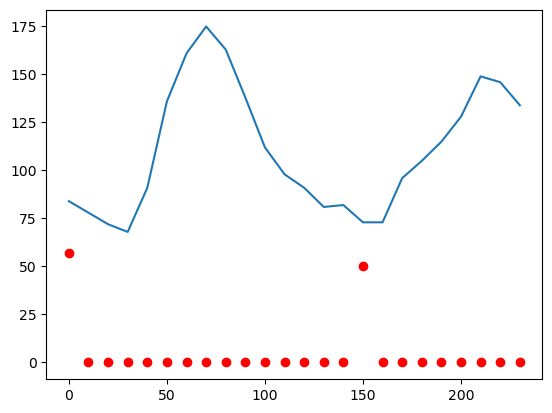

In [7]:
plt.plot(carbIntake[0]["minAfterMeal"], carbIntake[0]["cbg"])
plt.plot(carbIntake[0]["minAfterMeal"], carbIntake[0]["carbInput"], "ro")

In [24]:
def train_model(i = 0):
    # Random seed from reproducibility
    # random.Random(42).shuffle(carbIntake)
    # Perform train-test split on the combined DataFrame
    train = carbIntake[:int(0.8*len(carbIntake))][i]
    test = carbIntake[int(0.8*len(carbIntake)):][1]

    # Data is scaled using MinMaxScaler to ensure that all features are within the same range, typically between 0 and 1.
    scaler = MinMaxScaler()
    # train_scaled = scaler.fit_transform(train)
    # test_scaled = scaler.transform(test)

    X_train = train.drop(["cbg", "gsr", "basal"], axis=1)
    y_train = train["cbg"]


    carbInput = train[train["carbInput"] > 0]

    # Linear Regression
    # Train the linear regression model on the scaled data
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    
    # Make predictions
    y_train_pred = model.predict(X_train)

    # SVR model
    # model = SVR(kernel='rbf', gamma=0.3, C=10, epsilon=0.4)

    # # Fit the model
    # model.fit(X_train, y_train)
    # y_train_pred = model.predict(X_train).reshape(-1,1)
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))
    axs[0].plot(X_train.minAfterMeal, y_train, label="Ground Truth")
    axs[0].plot(X_train.minAfterMeal,y_train_pred, label="Prediction")
    axs[0].plot(carbInput.minAfterMeal, carbInput.carbInput, "ro")
    axs[1].bar(X_train.columns.values, model.coef_)
    
    # plt.legend()

/var/folders/50/40hhzd5j4_5fr1sv5_b997z00000gn/T/ipykernel_55081/1611279002.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

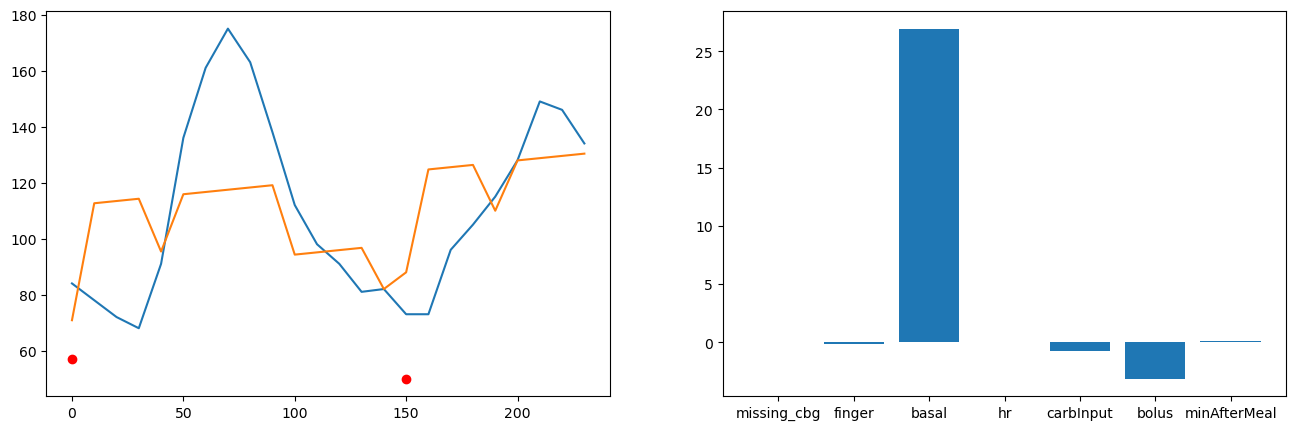

<Figure size 640x480 with 0 Axes>

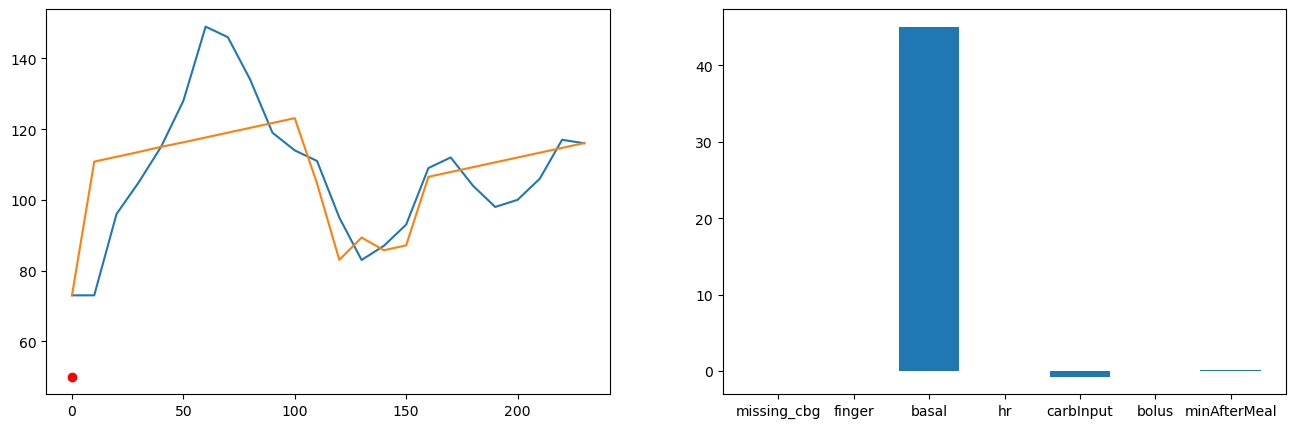

<Figure size 640x480 with 0 Axes>

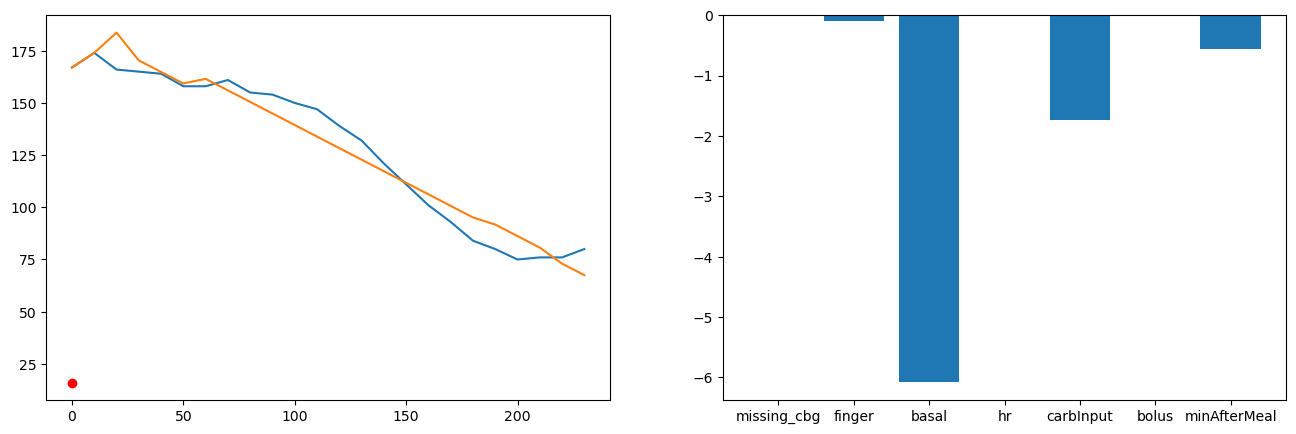

<Figure size 640x480 with 0 Axes>

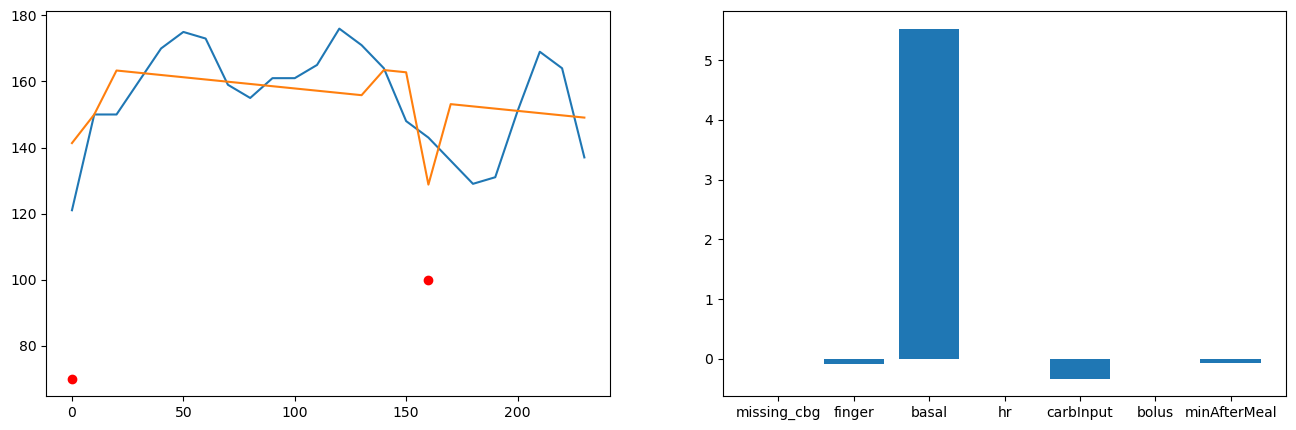

<Figure size 640x480 with 0 Axes>

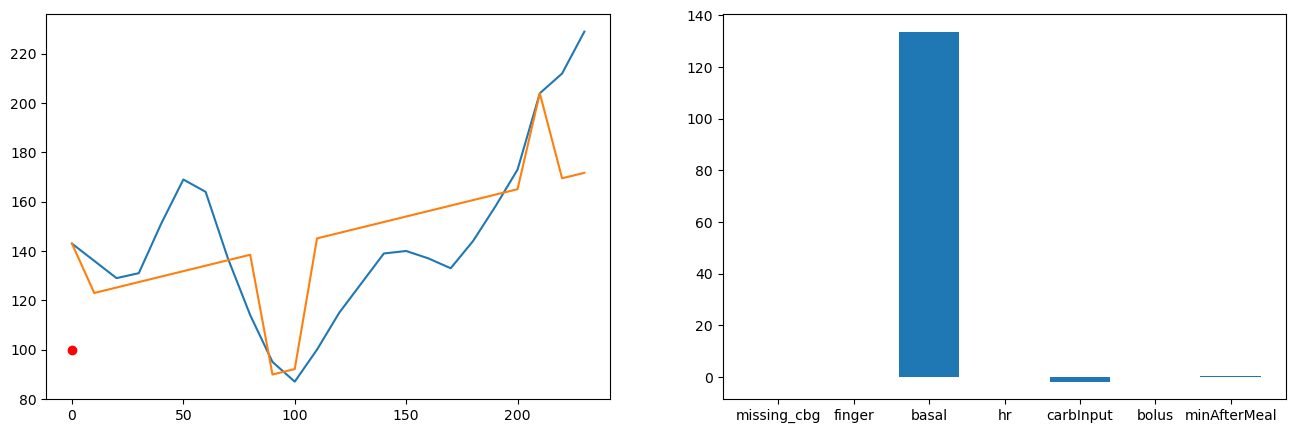

<Figure size 640x480 with 0 Axes>

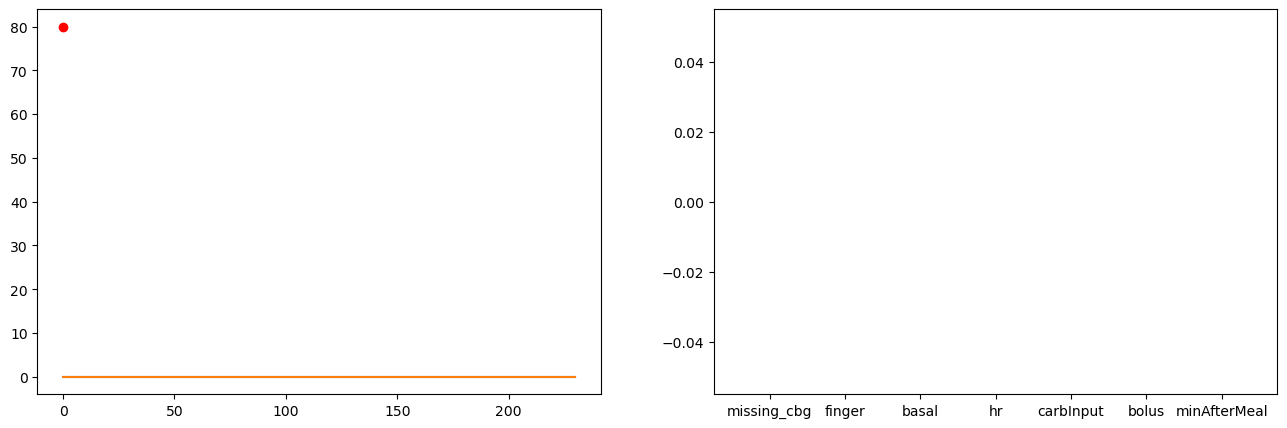

<Figure size 640x480 with 0 Axes>

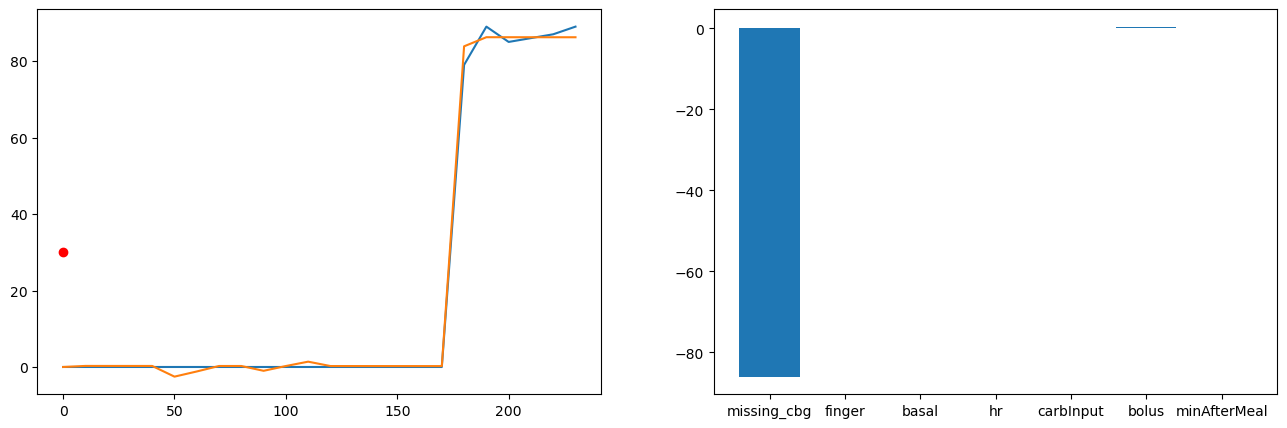

<Figure size 640x480 with 0 Axes>

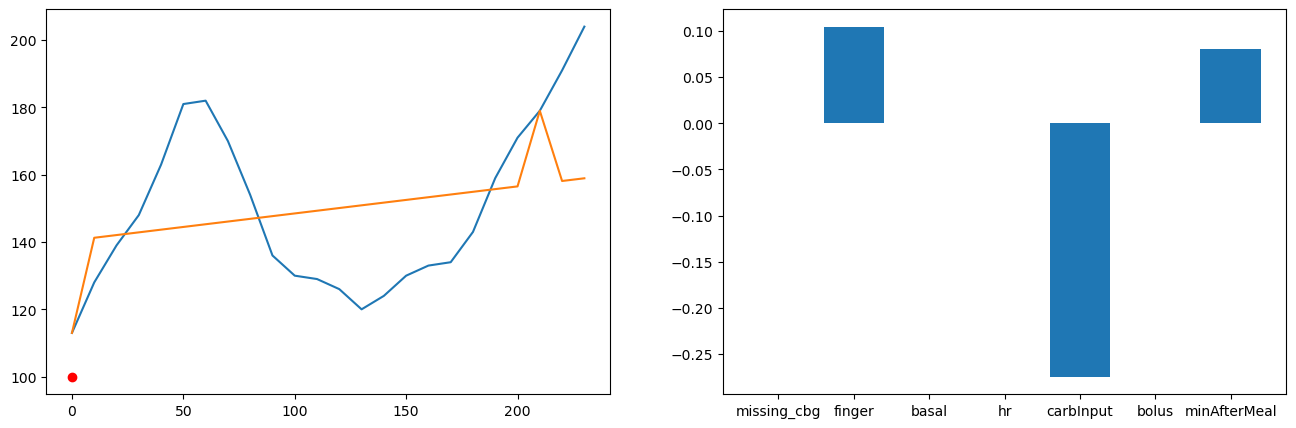

<Figure size 640x480 with 0 Axes>

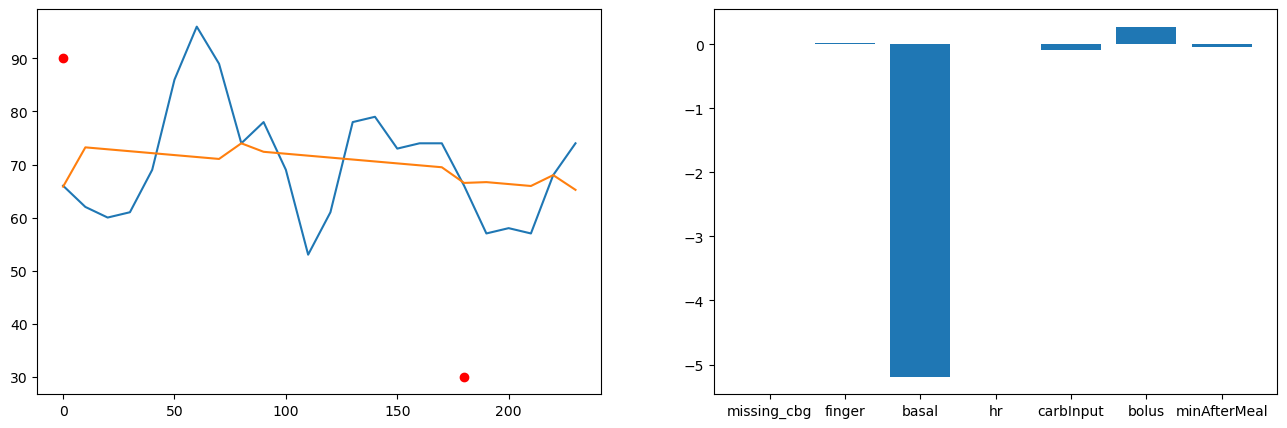

<Figure size 640x480 with 0 Axes>

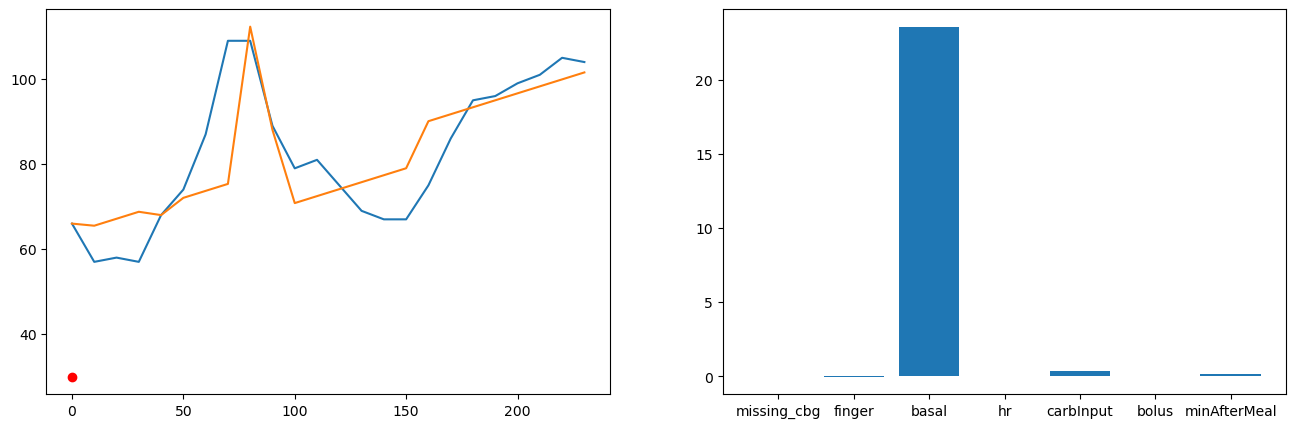

<Figure size 640x480 with 0 Axes>

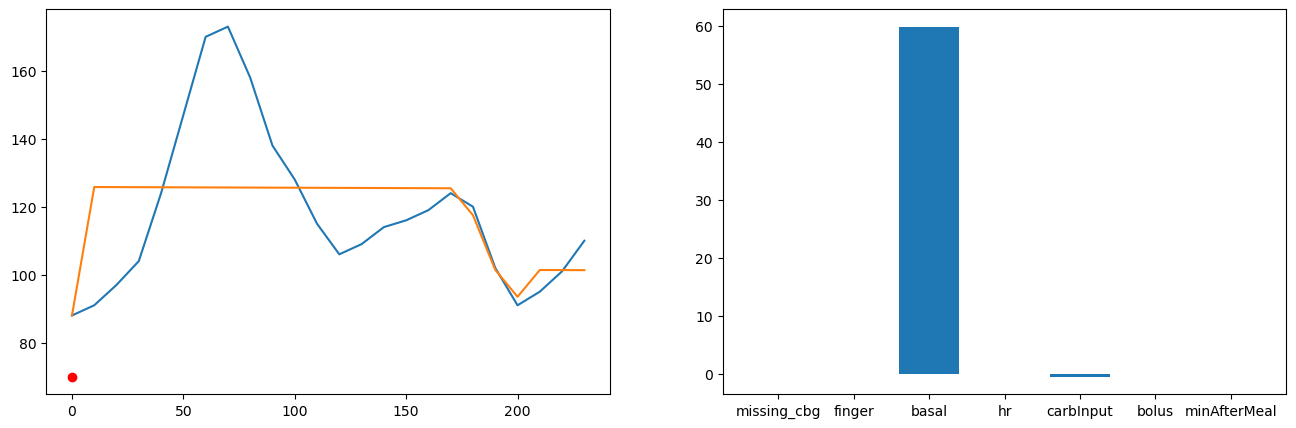

<Figure size 640x480 with 0 Axes>

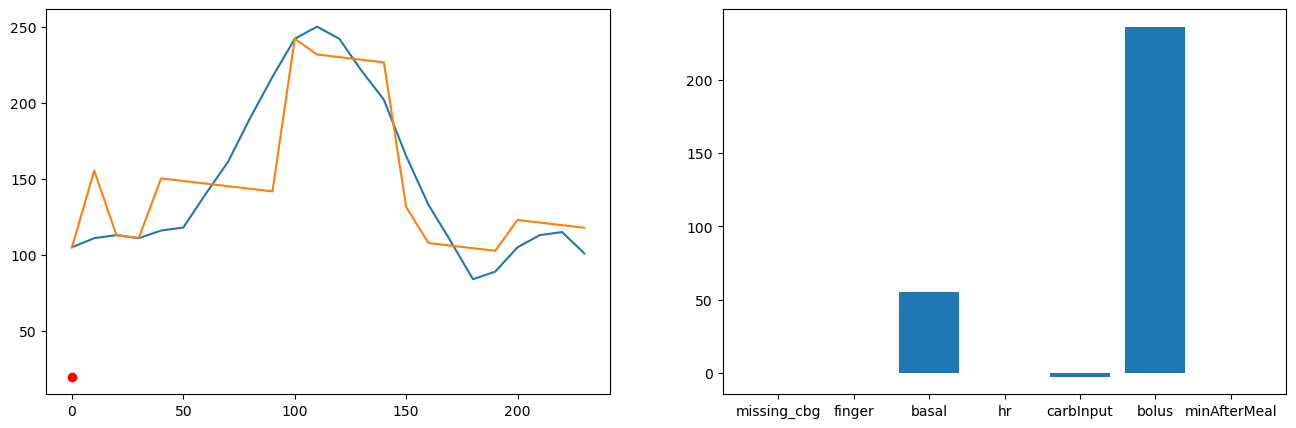

<Figure size 640x480 with 0 Axes>

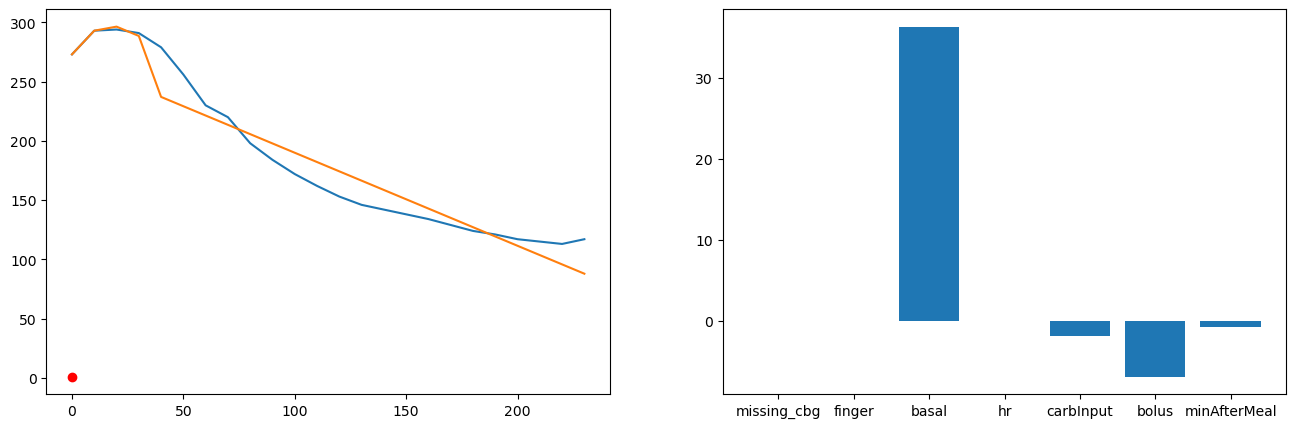

<Figure size 640x480 with 0 Axes>

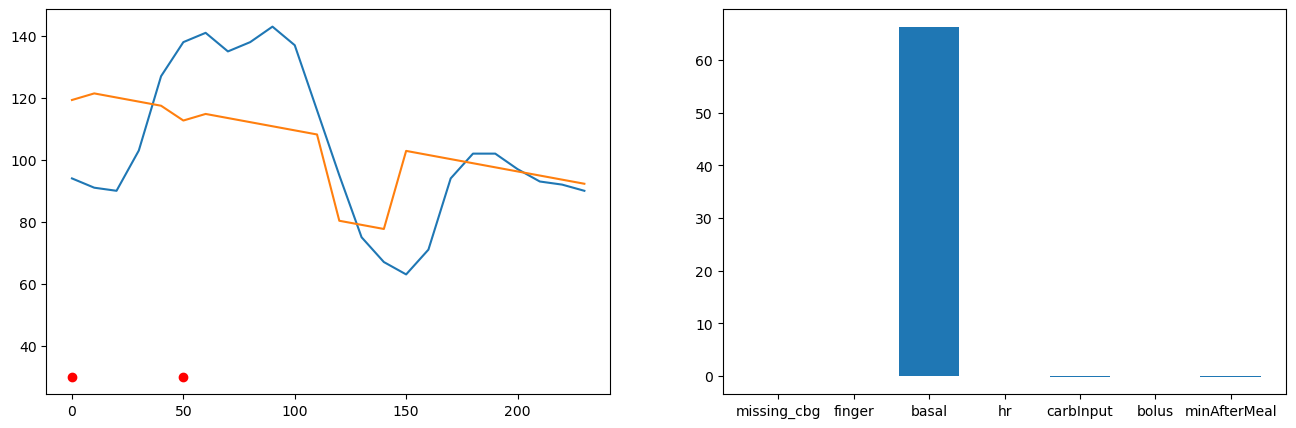

<Figure size 640x480 with 0 Axes>

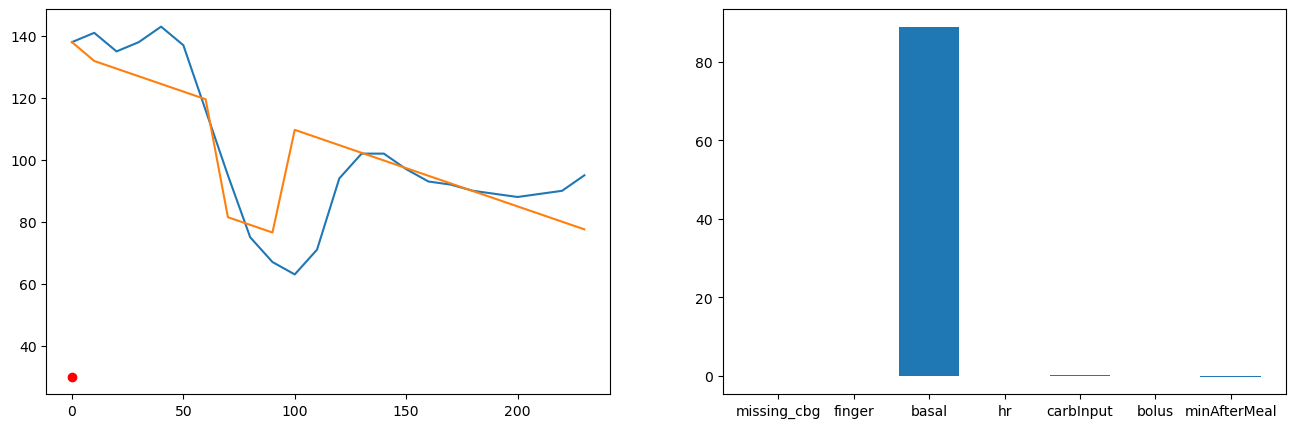

<Figure size 640x480 with 0 Axes>

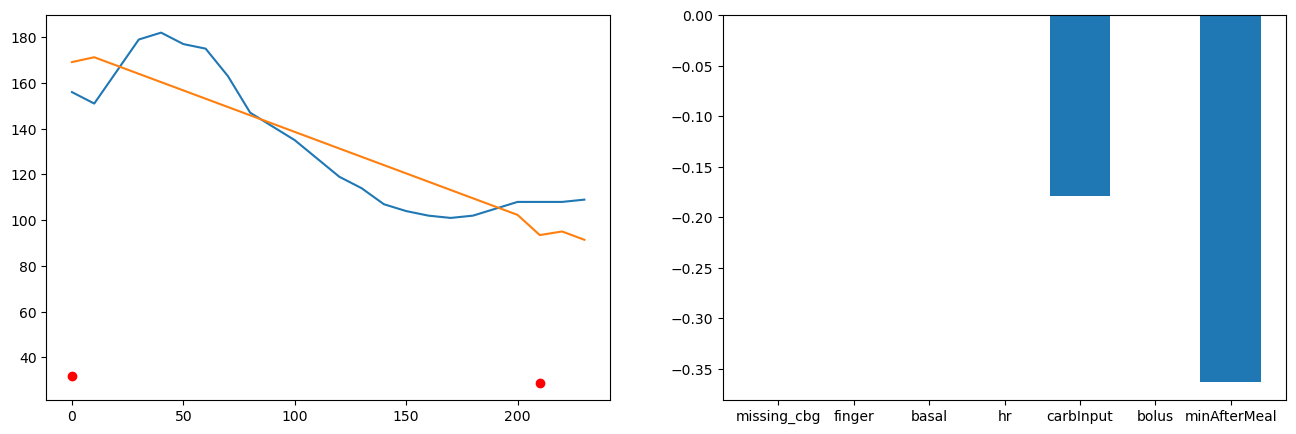

<Figure size 640x480 with 0 Axes>

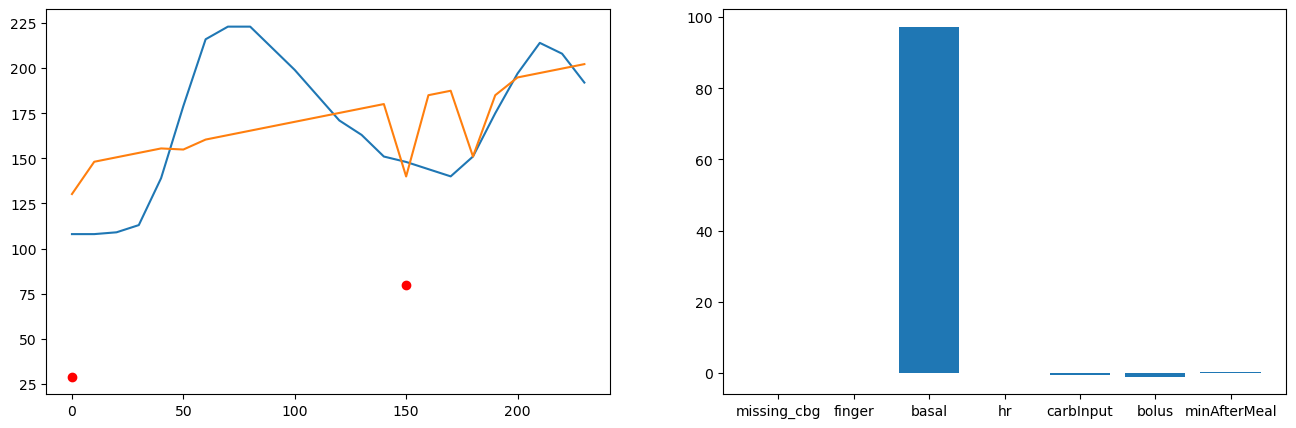

<Figure size 640x480 with 0 Axes>

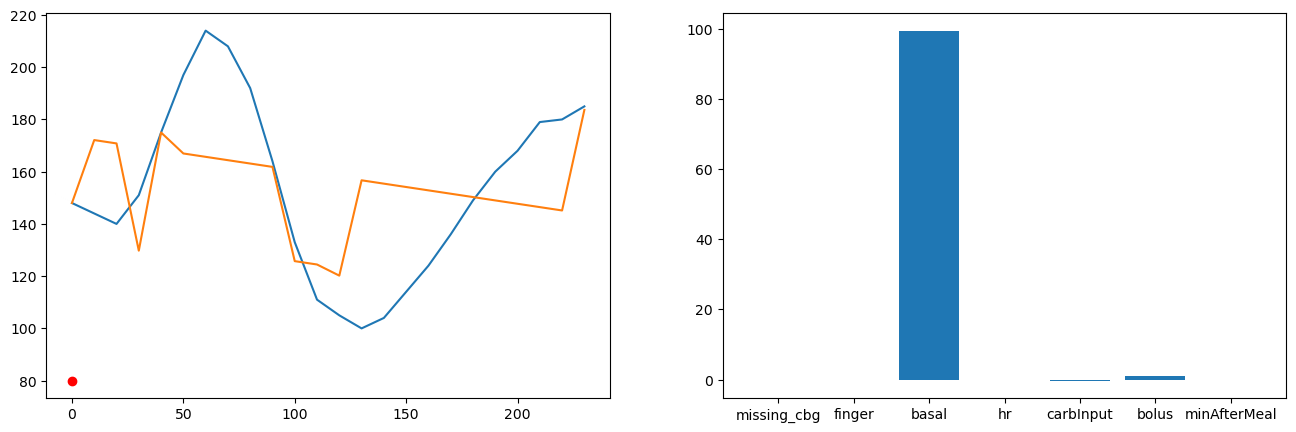

<Figure size 640x480 with 0 Axes>

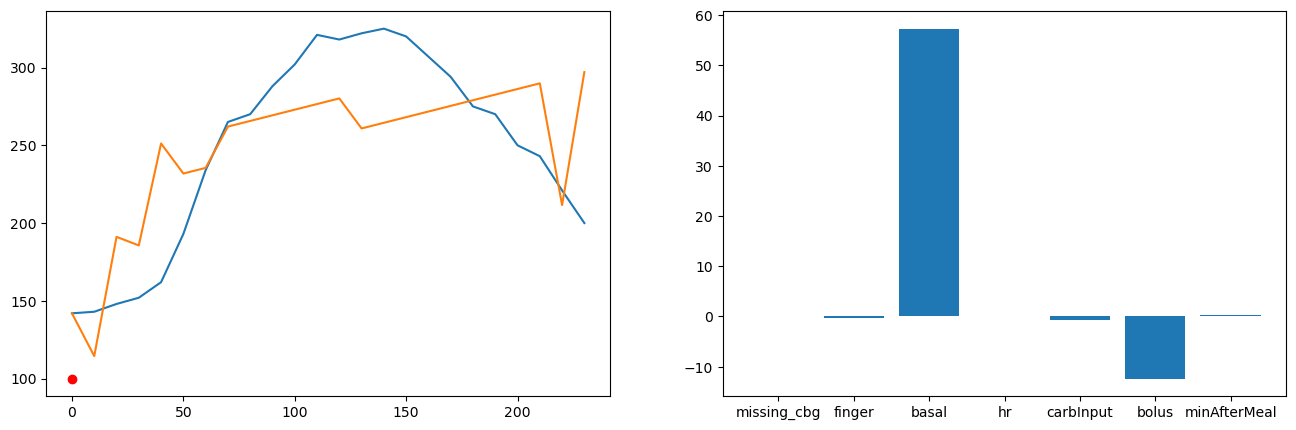

<Figure size 640x480 with 0 Axes>

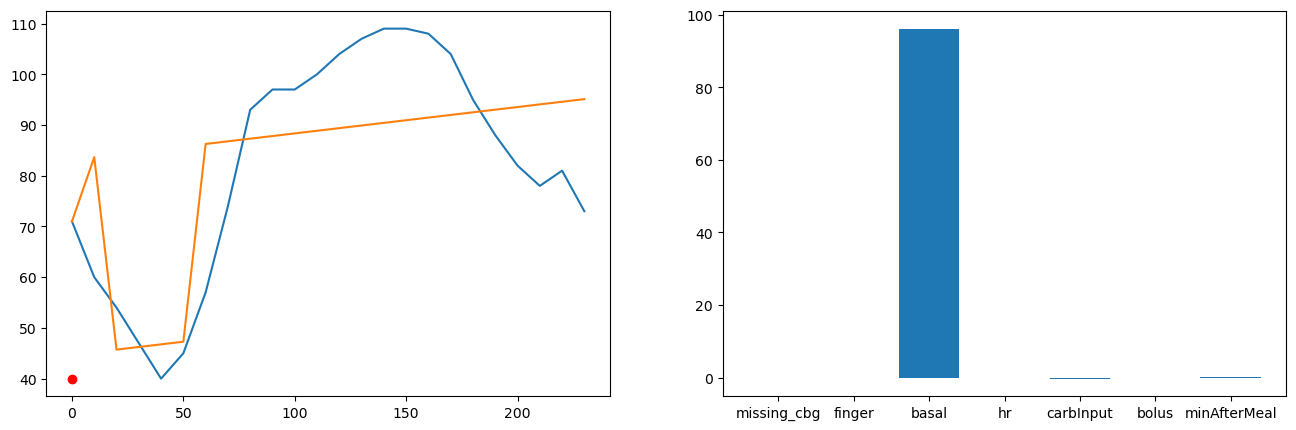

<Figure size 640x480 with 0 Axes>

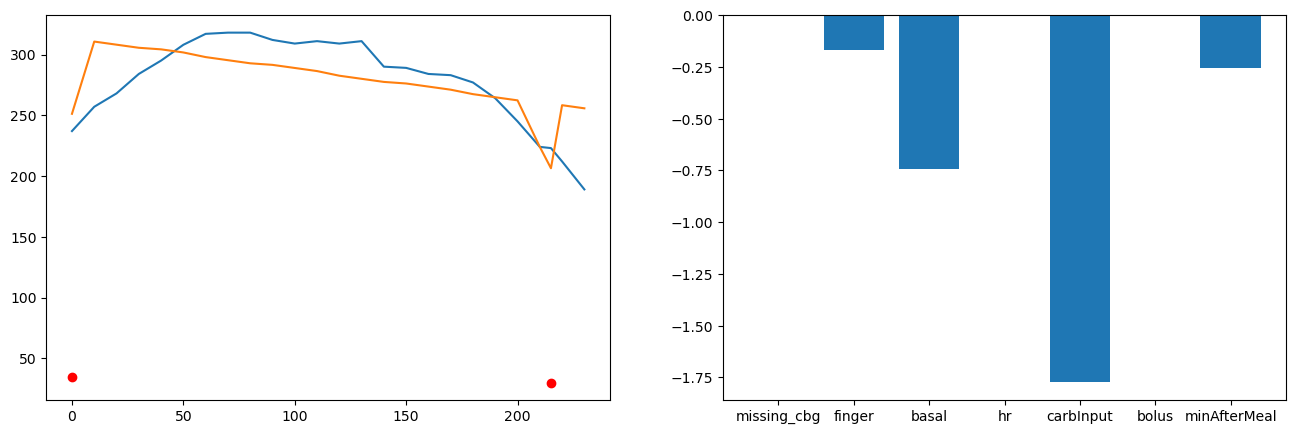

<Figure size 640x480 with 0 Axes>

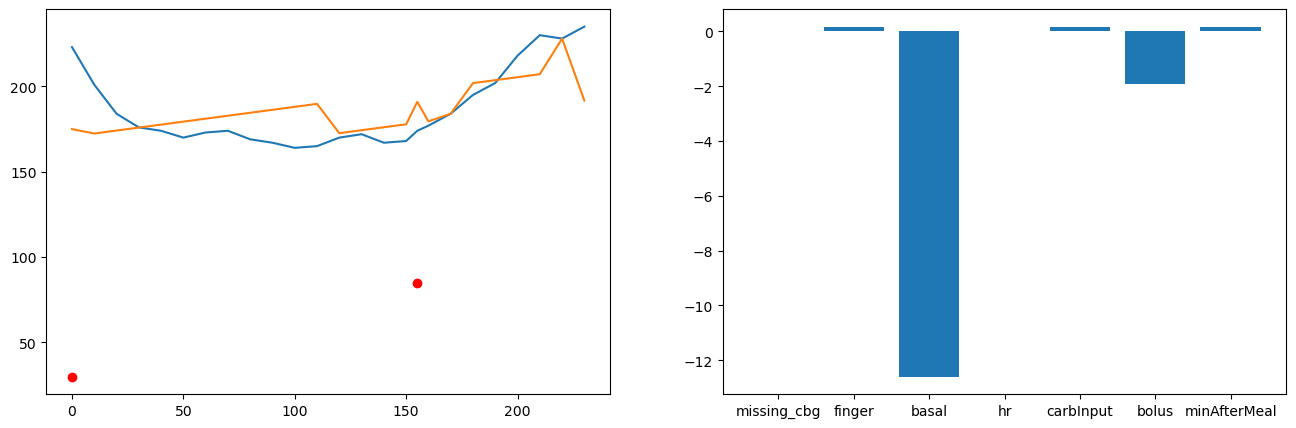

<Figure size 640x480 with 0 Axes>

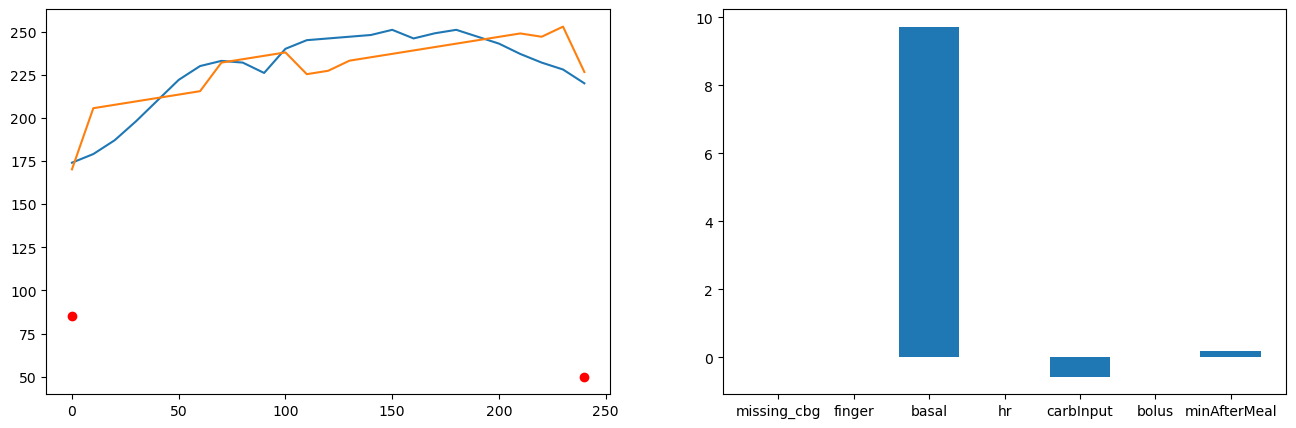

<Figure size 640x480 with 0 Axes>

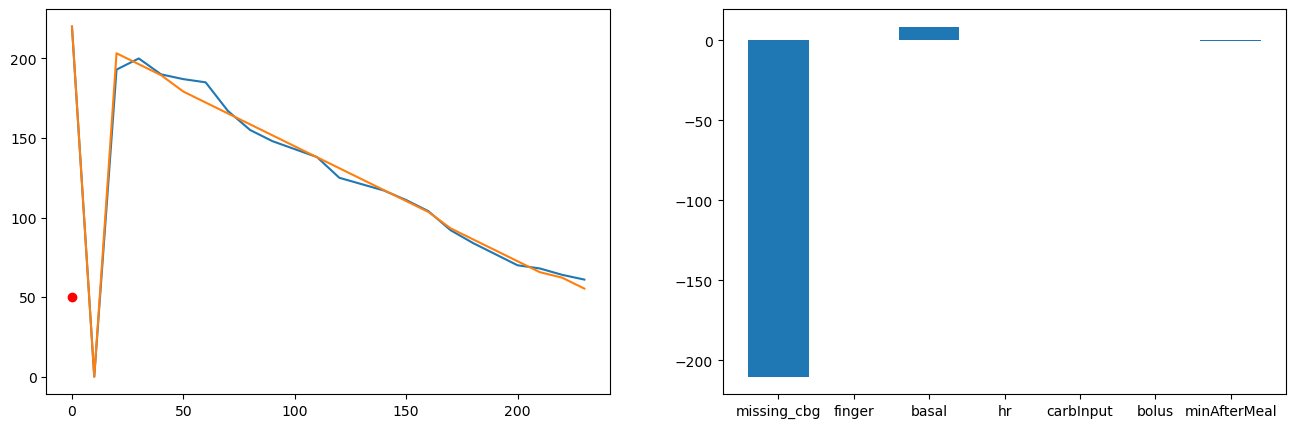

<Figure size 640x480 with 0 Axes>

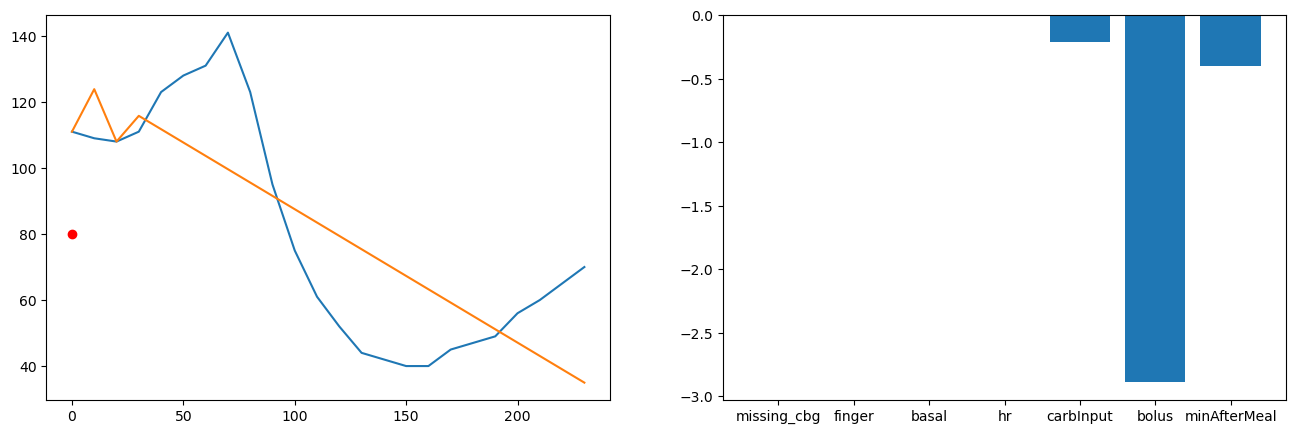

<Figure size 640x480 with 0 Axes>

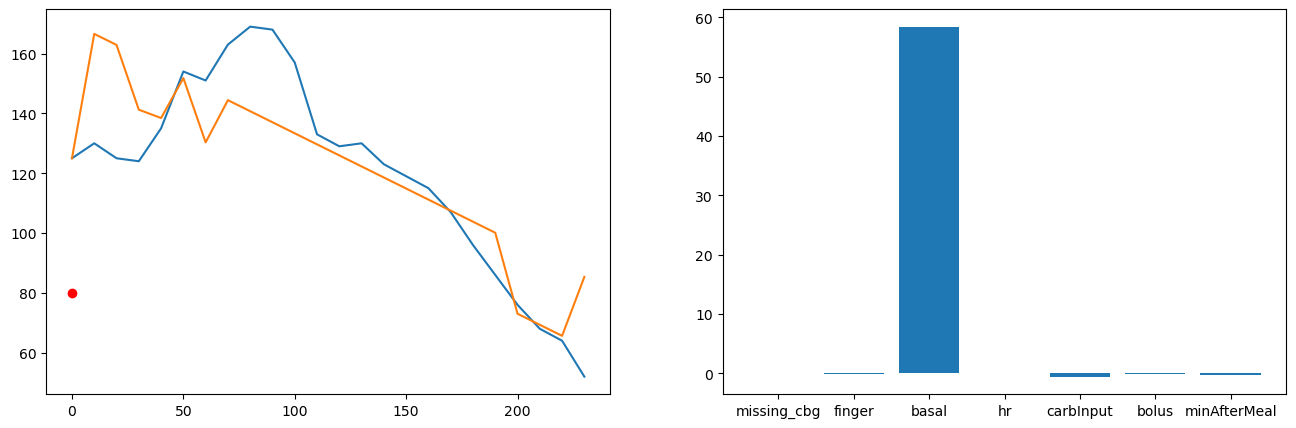

<Figure size 640x480 with 0 Axes>

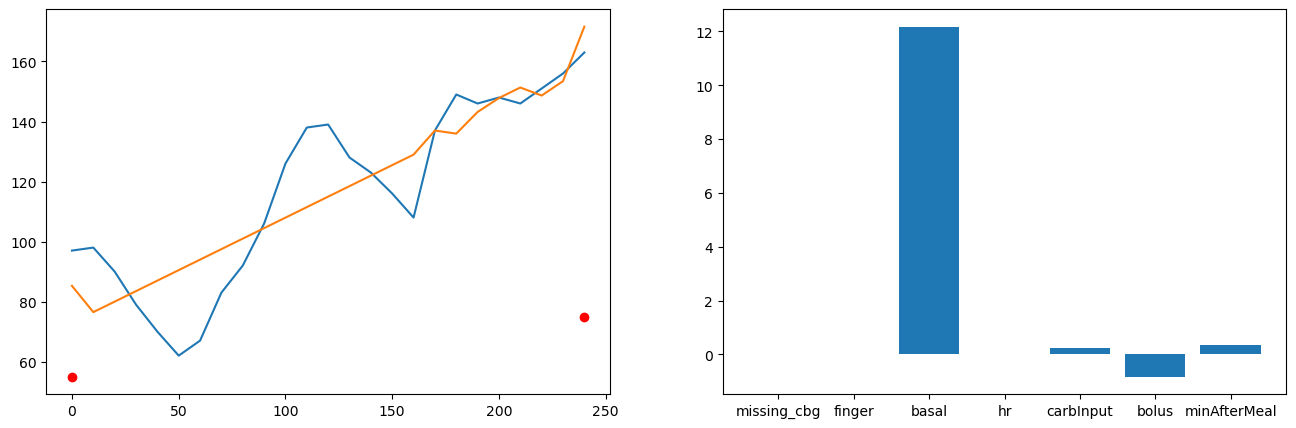

<Figure size 640x480 with 0 Axes>

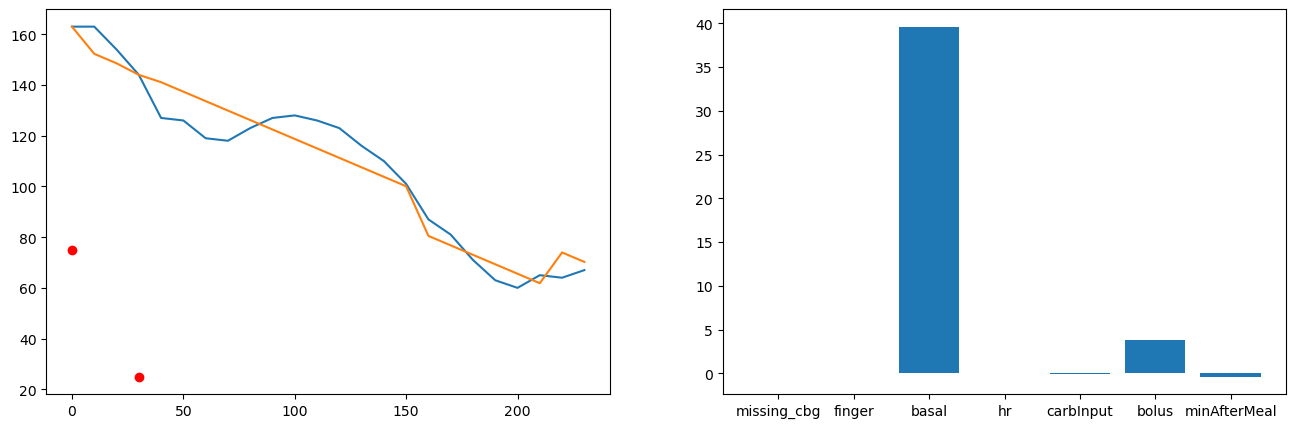

<Figure size 640x480 with 0 Axes>

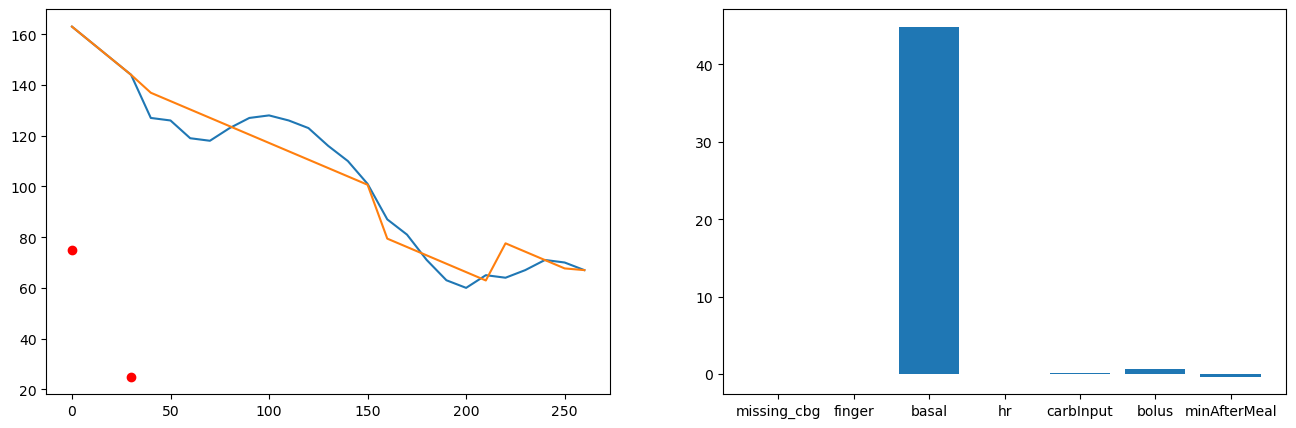

<Figure size 640x480 with 0 Axes>

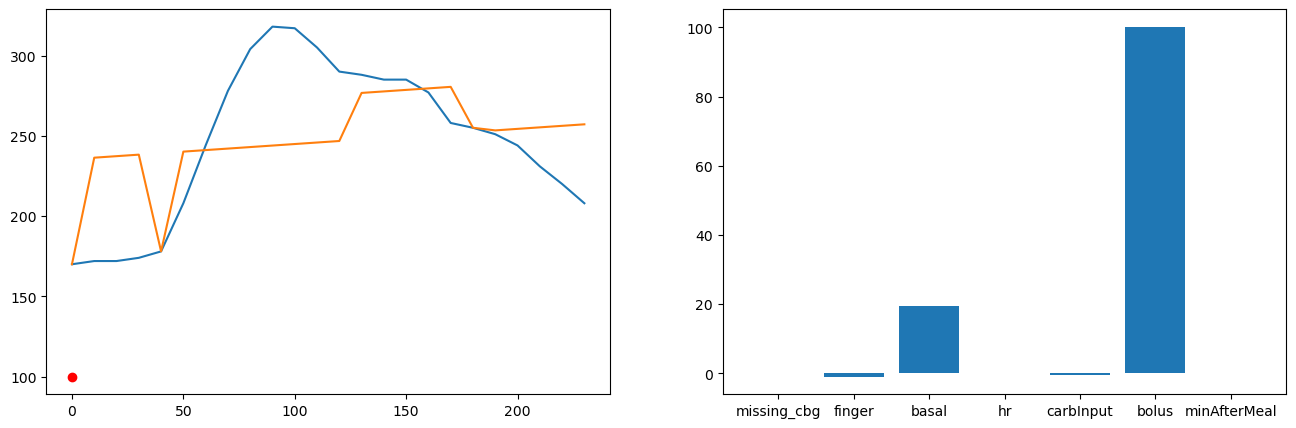

<Figure size 640x480 with 0 Axes>

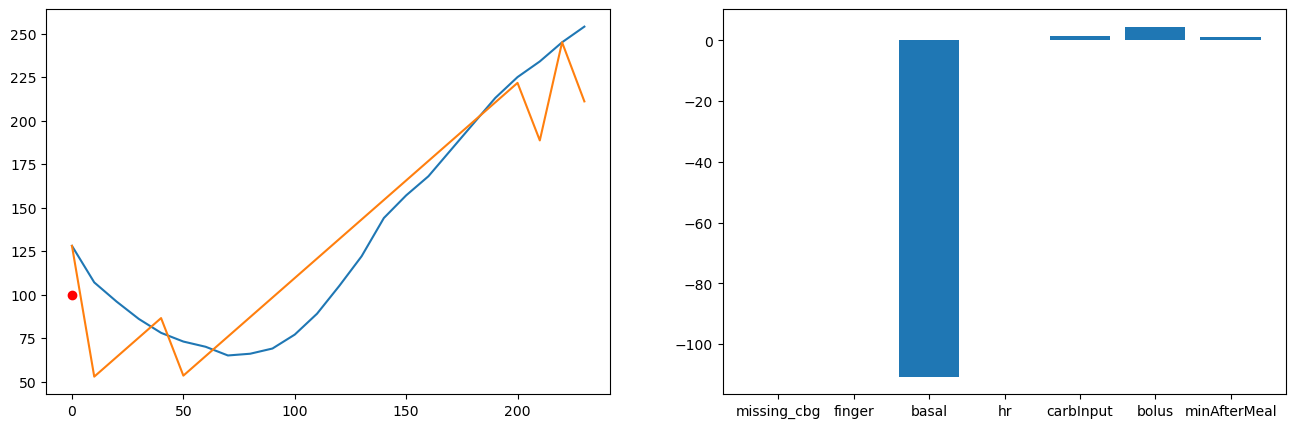

<Figure size 640x480 with 0 Axes>

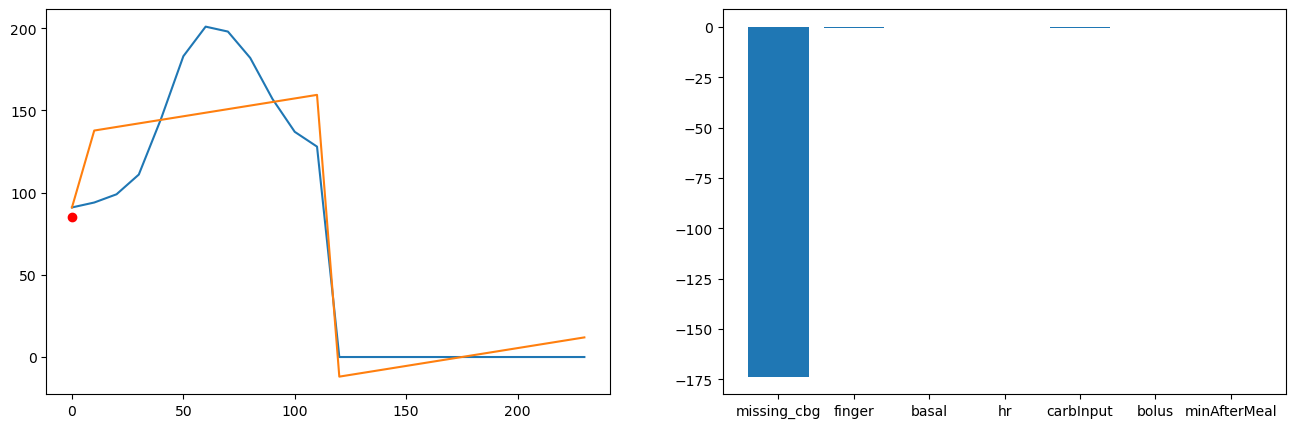

<Figure size 640x480 with 0 Axes>

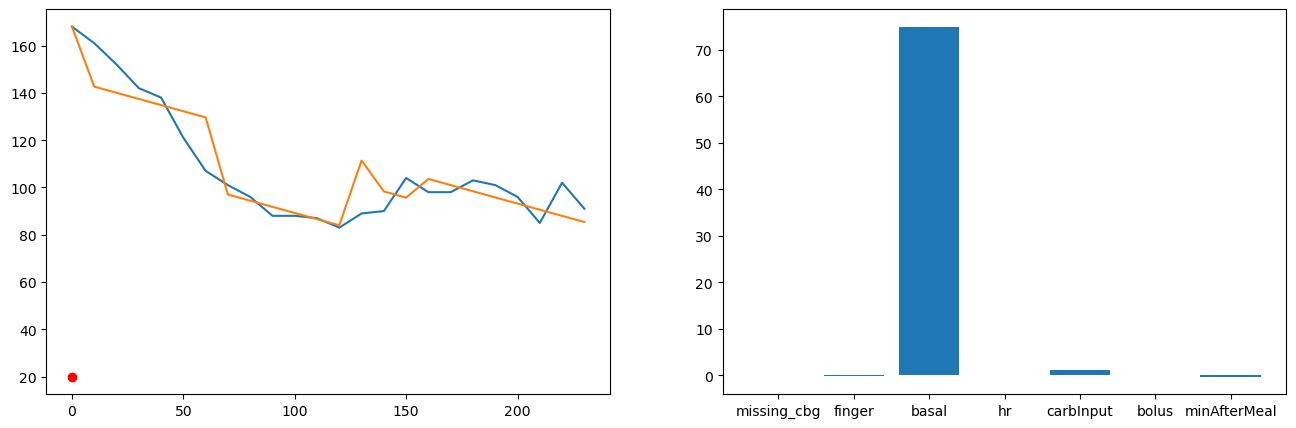

<Figure size 640x480 with 0 Axes>

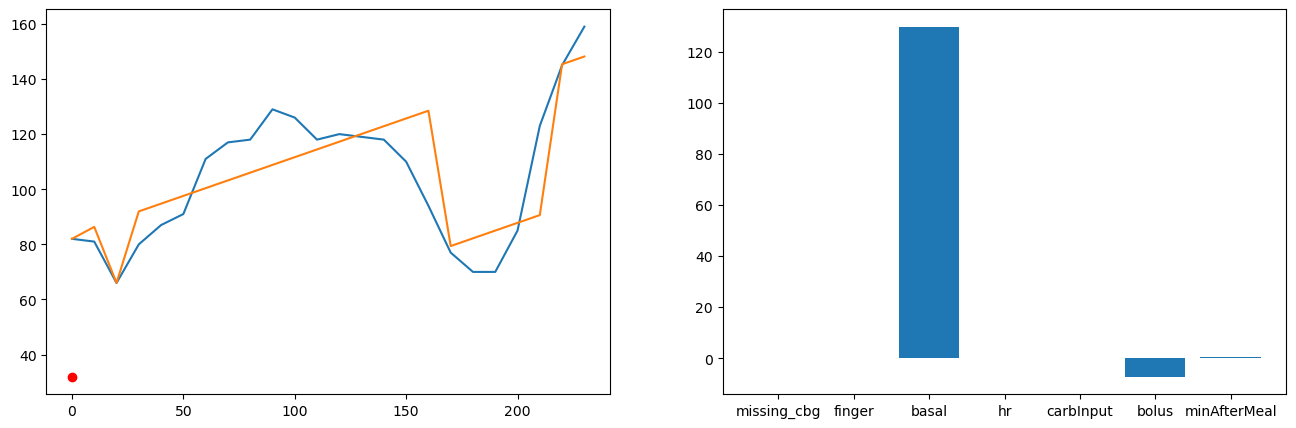

<Figure size 640x480 with 0 Axes>

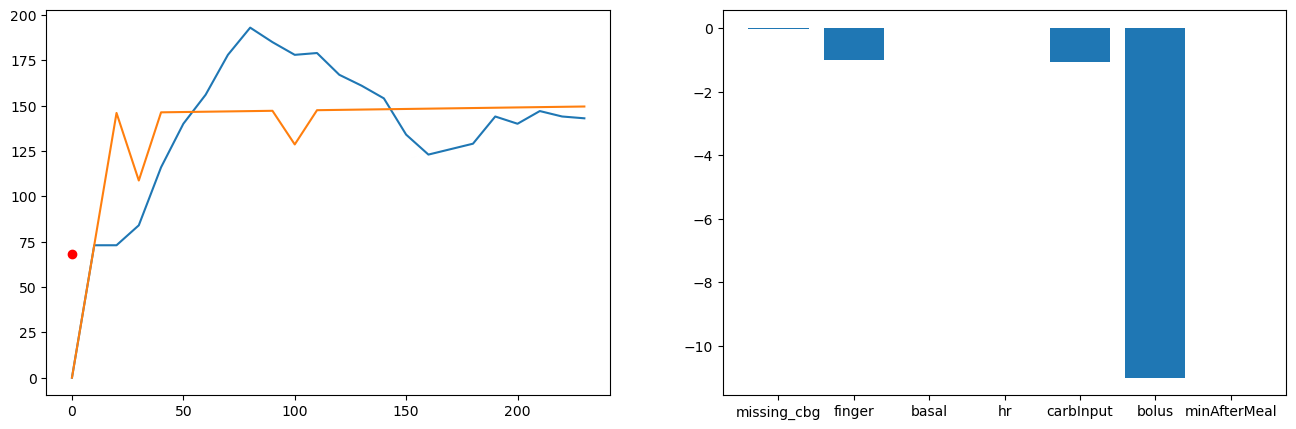

<Figure size 640x480 with 0 Axes>

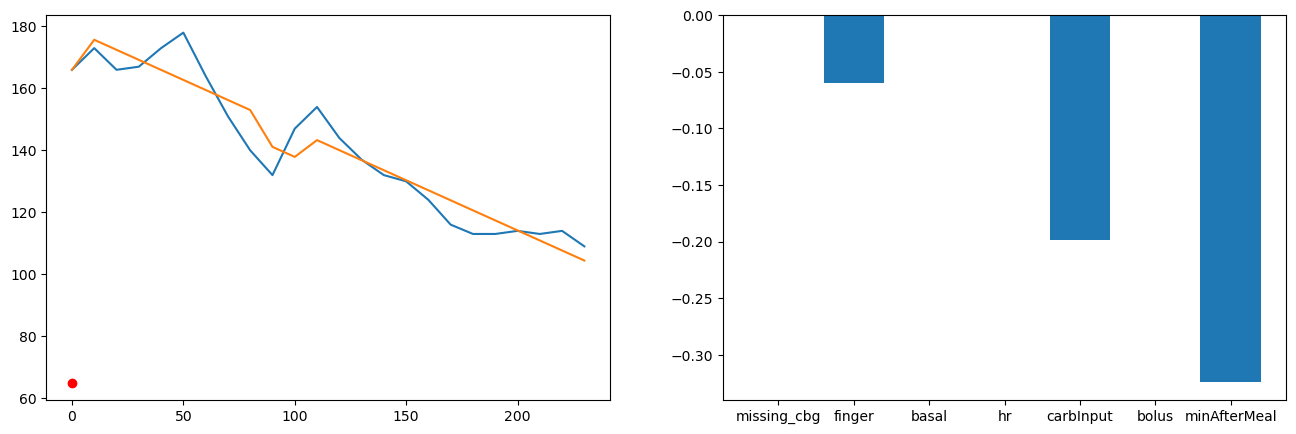

<Figure size 640x480 with 0 Axes>

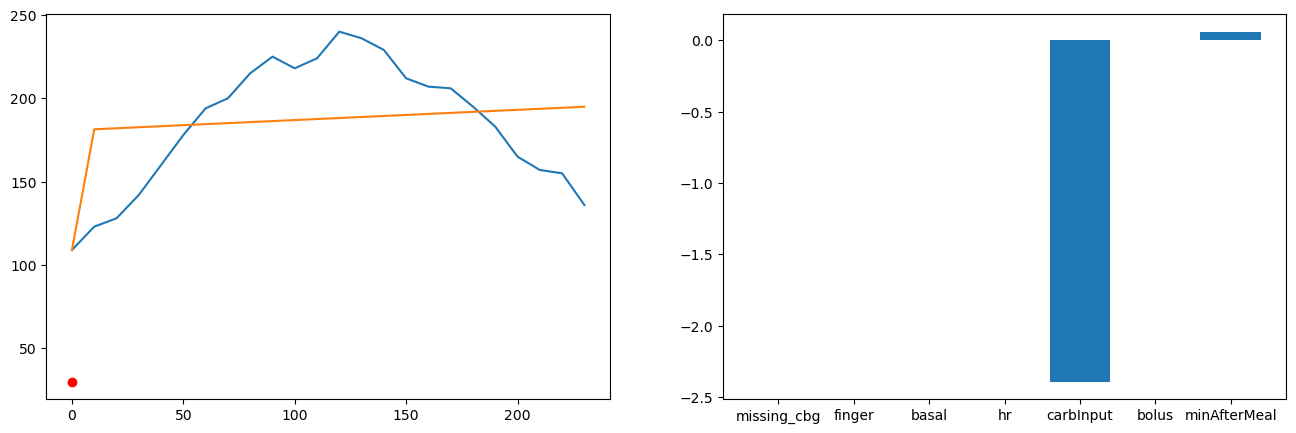

<Figure size 640x480 with 0 Axes>

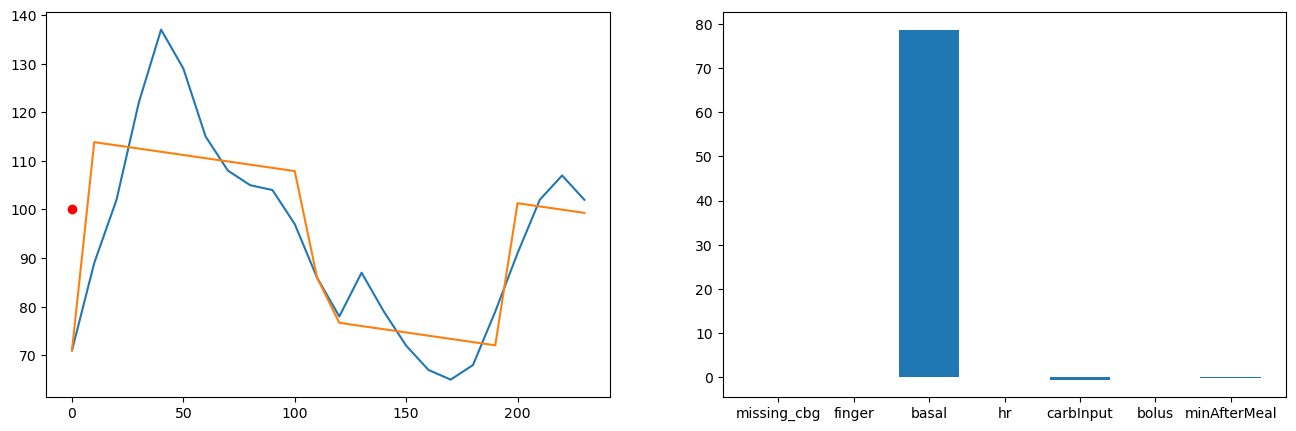

<Figure size 640x480 with 0 Axes>

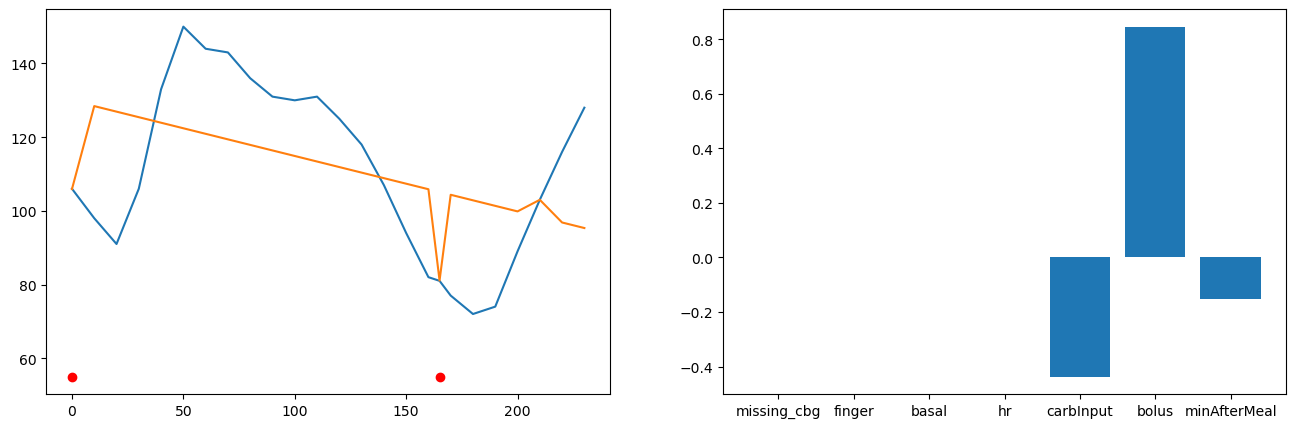

<Figure size 640x480 with 0 Axes>

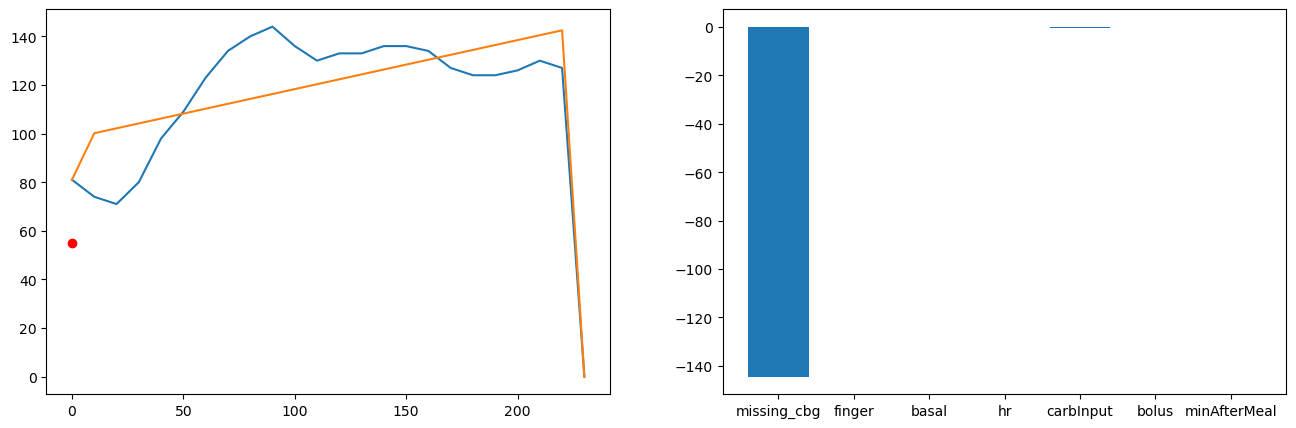

<Figure size 640x480 with 0 Axes>

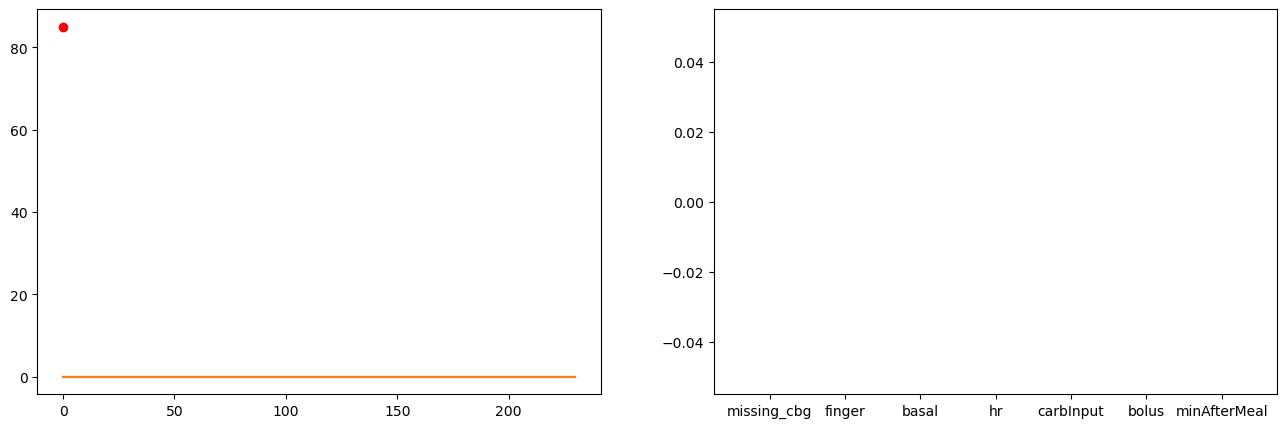

<Figure size 640x480 with 0 Axes>

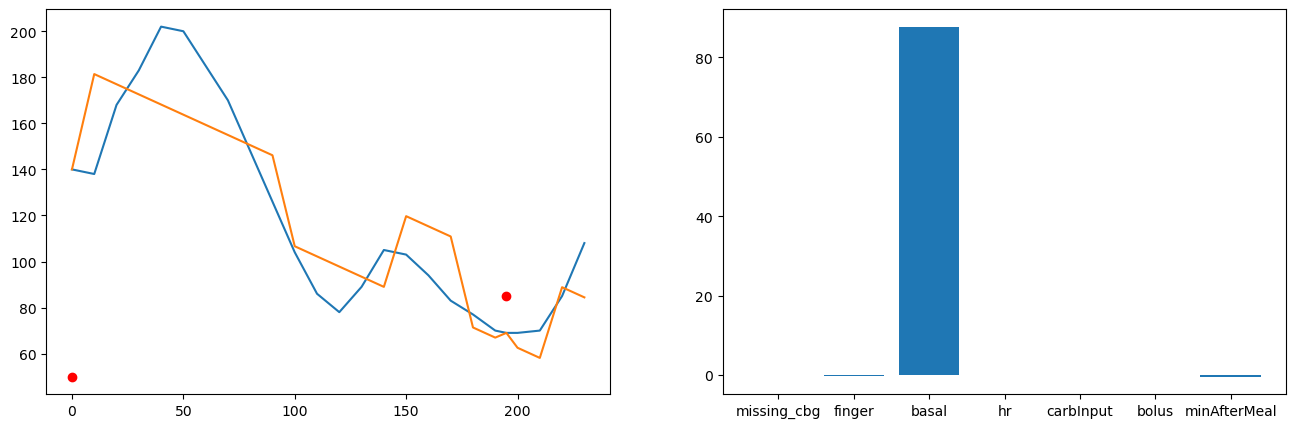

<Figure size 640x480 with 0 Axes>

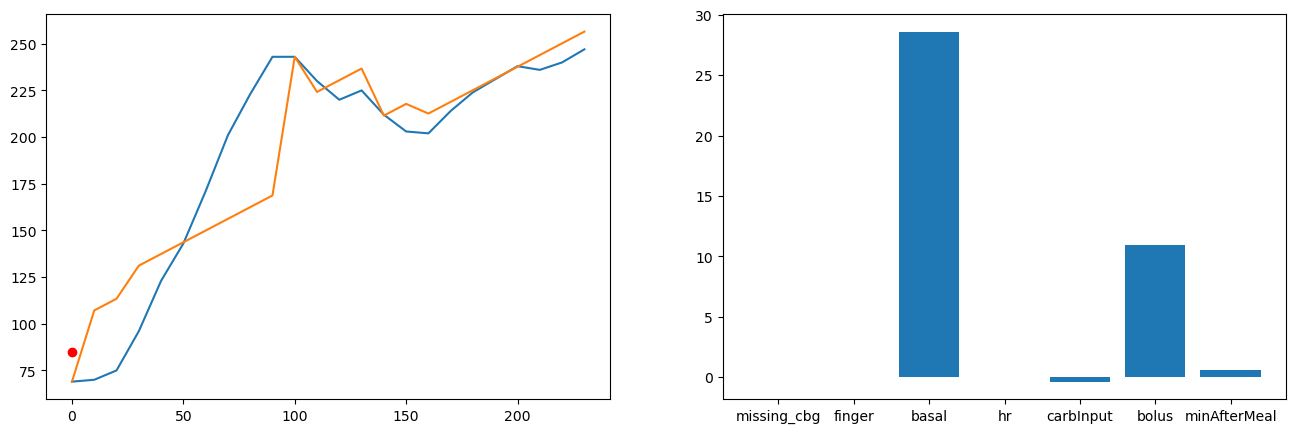

<Figure size 640x480 with 0 Axes>

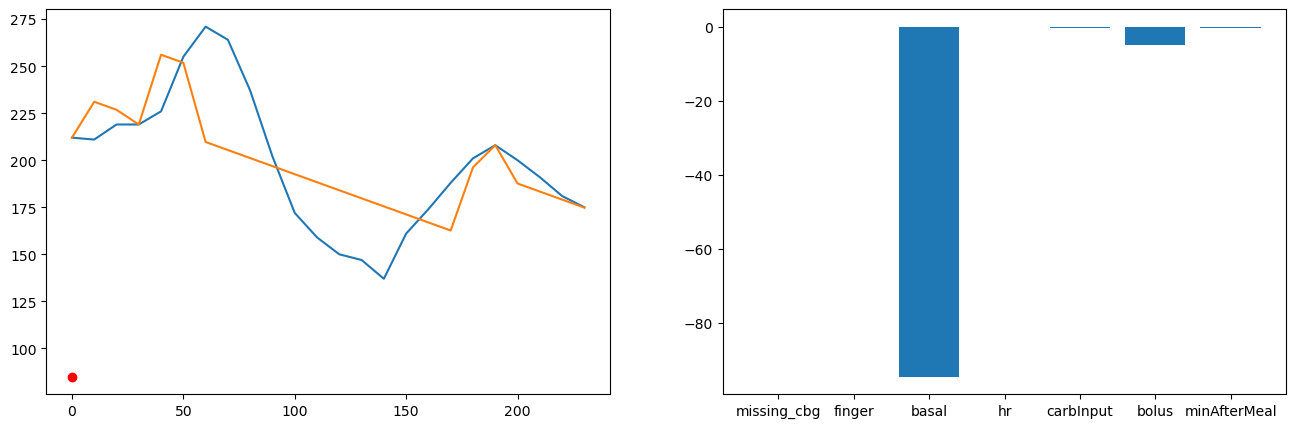

<Figure size 640x480 with 0 Axes>

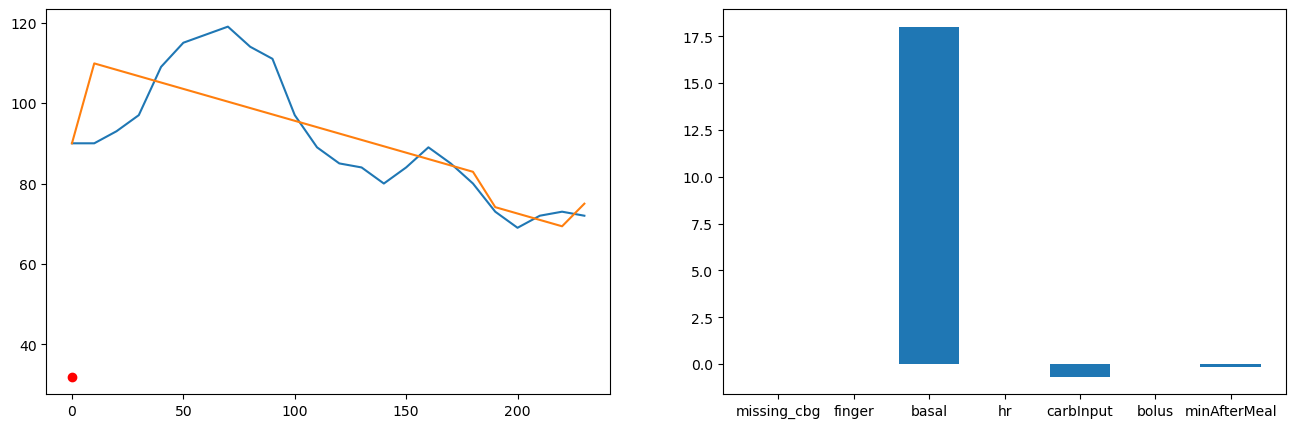

<Figure size 640x480 with 0 Axes>

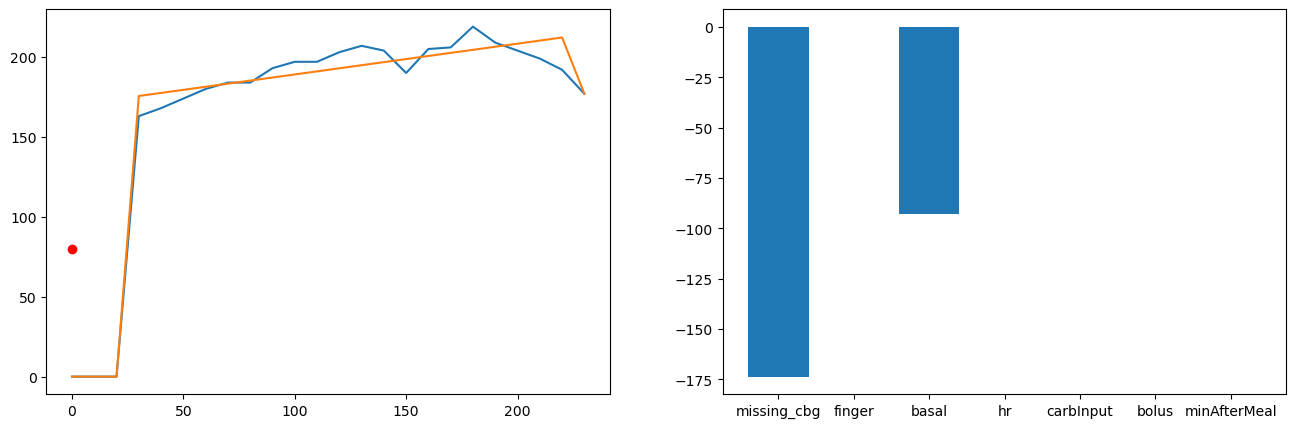

<Figure size 640x480 with 0 Axes>

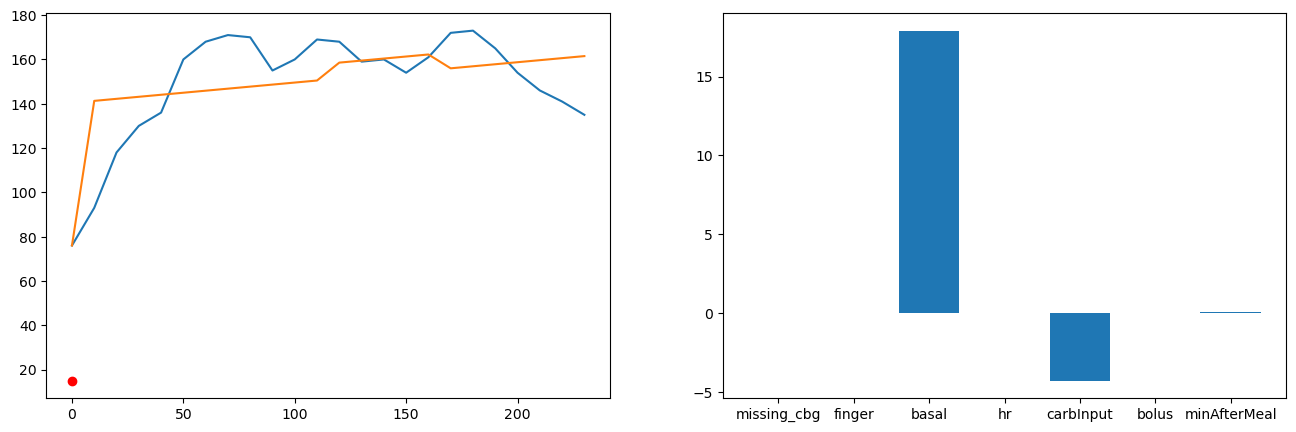

<Figure size 640x480 with 0 Axes>

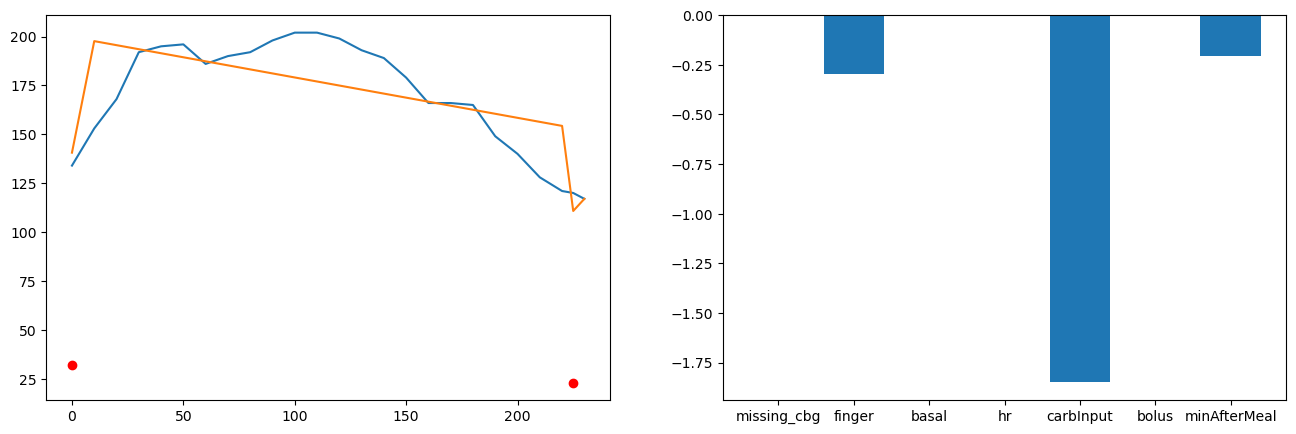

<Figure size 640x480 with 0 Axes>

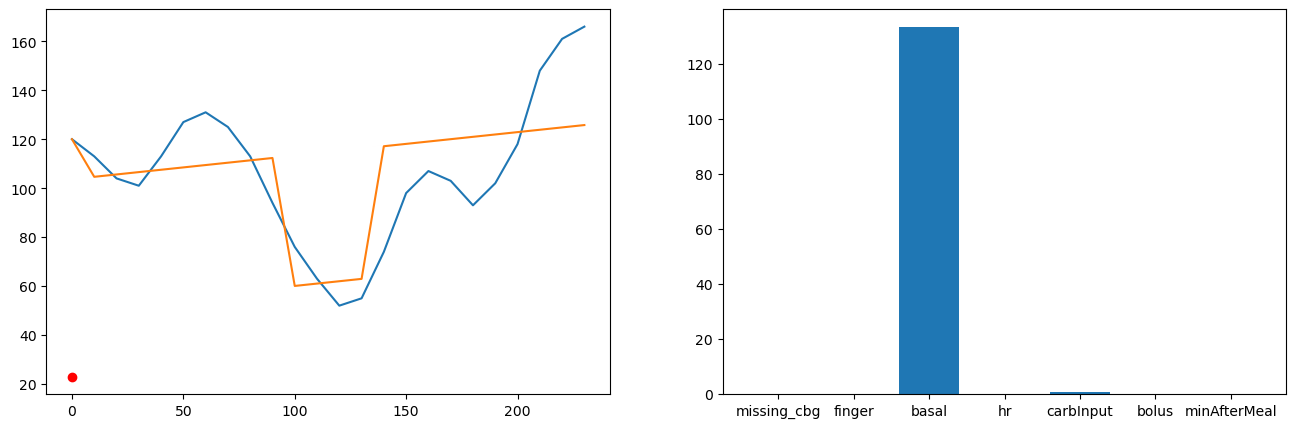

<Figure size 640x480 with 0 Axes>

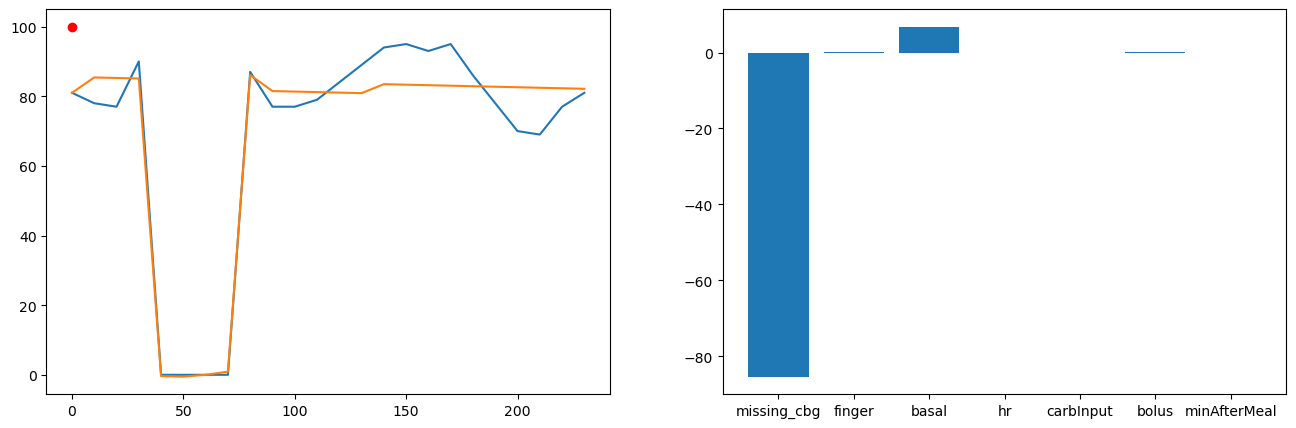

In [25]:
for i in range(50):
    plt.figure()
    train_model(i)


In [14]:
model.coef_

AttributeError: coef_ is only available when using a linear kernel

In [100]:
# Random seed from reproducibility
# random.Random(42).shuffle(carbIntake)
# Perform train-test split on the combined DataFrame
train = carbIntake[:int(0.8*len(carbIntake))][0]
test = carbIntake[int(0.8*len(carbIntake)):][1]

# Data is scaled using MinMaxScaler to ensure that all features are within the same range, typically between 0 and 1.
scaler = MinMaxScaler()
# train_scaled = scaler.fit_transform(train)
# test_scaled = scaler.transform(test)

X_train = train.drop("cbg", axis=1)
y_train = train["cbg"]


In [101]:
# SVR model
model = SVR(kernel='rbf', gamma=0.3, C=10, epsilon=0.4)

# Fit the model
model.fit(X_train, y_train)

SVR(C=10, epsilon=0.4, gamma=0.3)

In [102]:
y_train_pred = model.predict(X_train).reshape(-1,1)

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

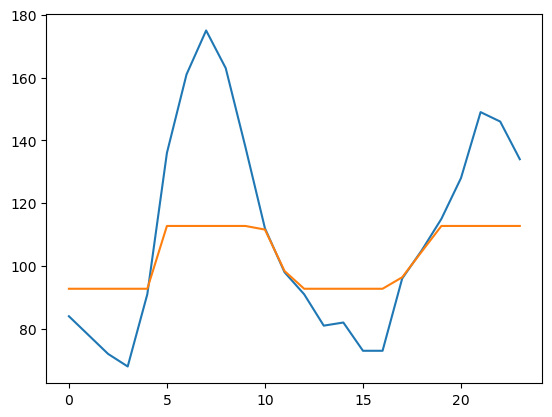

In [103]:
plt.plot(X_train.index, y_train, label="Ground Truth")
plt.plot(X_train.index,y_train_pred, label="Prediction")
plt.legend

In [104]:
plt.figure(figsize=(15,6))
plt.bar(X_train.columns.values, model.coef_)

AttributeError: coef_ is only available when using a linear kernel

<Figure size 1500x600 with 0 Axes>

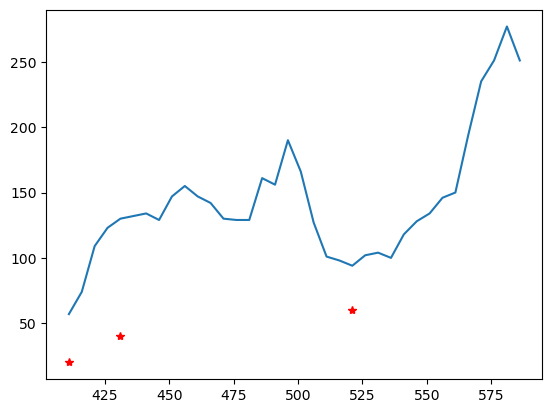

In [145]:
plt.plot(carbIntakeData["5minute_intervals_timestamp"], carbIntakeData["cbg"])
plt.plot(carbIntakeData["5minute_intervals_timestamp"], carbIntakeData["carbInput"], "r*")

In [117]:
df[df["carbInput"] > 0]

,5minute_intervals_timestamp,missing_cbg,cbg,finger,basal,hr,gsr,carbInput,bolus
365,365.044089,0.0,147.0,NaN,2.00,NaN,NaN,60.0,NaN
411,411.049645,0.0,57.0,NaN,0.00,NaN,11.539119,20.0,NaN
431,431.052061,0.0,130.0,NaN,1.90,NaN,3.409043,40.0,NaN
521,521.062932,0.0,94.0,NaN,1.65,NaN,6.157896,60.0,NaN
655,655.079118,0.0,187.0,NaN,1.65,NaN,0.481558,60.0,NaN
...,...,...,...,...,...,...,...,...,...
12527,12528.513151,0.0,196.0,NaN,1.65,NaN,0.740664,60.0,NaN
12604,12605.522452,0.0,222.0,NaN,1.65,NaN,0.564727,60.0,NaN
12629,12630.525472,1.0,NaN,NaN,1.65,NaN,0.357341,15.0,NaN
12893,12894.557361,1.0,NaN,NaN,1.65,NaN,0.404166,60.0,NaN


In [60]:
df["5minute_intervals_timestamp"][0]

0.0

In [61]:
df['5minute_intervals_timestamp'] = pd.to_datetime(df['5minute_intervals_timestamp'], unit='ms')
df

,5minute_intervals_timestamp,missing_cbg,cbg,finger,basal,hr,gsr,carbInput,bolus
0,1970-01-01 00:00:00.000000000,0.0,76.0,80.0,NaN,NaN,0.337214,NaN,NaN
1,1970-01-01 00:00:00.001000080,0.0,72.0,NaN,NaN,NaN,0.317671,NaN,NaN
2,1970-01-01 00:00:00.002000160,0.0,68.0,NaN,NaN,NaN,0.342821,NaN,NaN
3,1970-01-01 00:00:00.003000240,0.0,65.0,NaN,NaN,NaN,0.359941,NaN,NaN
4,1970-01-01 00:00:00.004000320,0.0,63.0,NaN,NaN,NaN,0.365833,NaN,NaN
...,...,...,...,...,...,...,...,...,...
13104,1970-01-01 00:00:13.105049680,0.0,255.0,NaN,0.8,NaN,NaN,NaN,NaN
13105,1970-01-01 00:00:13.106049760,0.0,258.0,NaN,0.8,NaN,NaN,NaN,NaN
13106,1970-01-01 00:00:13.107049840,0.0,258.0,NaN,0.8,NaN,NaN,NaN,NaN
13107,1970-01-01 00:00:13.108049920,0.0,257.0,NaN,0.8,NaN,NaN,NaN,NaN


In [62]:
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

# Visualize the data
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['IPG2211A2N'], label='Electric Production')
plt.xlabel('Date')
plt.ylabel('Electric Production')
plt.title('Electric Production Data')
plt.legend()
plt.show()

KeyError: 'DATE'